# Visualize Experiment Results - Downstream Performance

This notebook should answer the questions: *Does imputation lead to better downstream performances?*

## Notebook Structure 

* Application Scenario 2 - Downstream Performance  
   * Categorical  Columns (Classification)
   * Numerical Columns (Regression)
   * Heterogenous Columns (Classification and Regression Combined)

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns

from pathlib import Path
from data_imputation_paper.experiment import read_experiment, read_csv_files

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Settings

In [2]:
sns.set(style="whitegrid")
sns.set_context('paper', font_scale=1.5)
mpl.rcParams['lines.linewidth'] = '2'

In [3]:
EXPERIMENT_PATH = Path("../data/experiments/cluster5/fully_observed/")
FIGURES_PATH = Path("../paper/figures/fully_observed/")

CLF_METRIC = "F1_macro"
REG_METRIC = "RMSE"

DOWNSTREAM_RESULT_TYPE = "downstream_performance_mean"
IMPUTE_RESULT_TYPE = "impute_performance_mean"

In [4]:
Path(FIGURES_PATH/DOWNSTREAM_RESULT_TYPE).mkdir(parents=True, exist_ok=True)

## Import the data

In [5]:
%%time

results = read_csv_files(read_experiment(EXPERIMENT_PATH), read_details=False)
results.head()

CPU times: user 1min 31s, sys: 2.44 s, total: 1min 33s
Wall time: 1min 38s


,experiment,imputer,task,missing_type,missing_fraction,strategy,column,result_type,metric,train,test,baseline,corrupted,imputed
0,fully_observed,AutoKerasImputer,40922,MAR,0.01,single_all,gyro_y,impute_performance_std,MAE,1.179853,1.120607,NaN,NaN,NaN
1,fully_observed,AutoKerasImputer,40922,MAR,0.01,single_all,gyro_y,impute_performance_std,MSE,23.152042,10.959723,NaN,NaN,NaN
2,fully_observed,AutoKerasImputer,40922,MAR,0.01,single_all,gyro_y,impute_performance_std,RMSE,1.425468,0.630841,NaN,NaN,NaN
3,fully_observed,AutoKerasImputer,40922,MAR,0.30,single_all,gyro_y,impute_performance_std,MAE,0.905889,0.471882,NaN,NaN,NaN
4,fully_observed,AutoKerasImputer,40922,MAR,0.30,single_all,gyro_y,impute_performance_std,MSE,13.756370,17.497516,NaN,NaN,NaN


In [6]:
na_impute_results = results[
    (results["result_type"] == IMPUTE_RESULT_TYPE) & 
    (results["metric"].isin([CLF_METRIC, REG_METRIC]))
]
na_impute_results.drop(["baseline", "corrupted", "imputed"], axis=1, inplace=True)
na_impute_results = na_impute_results[na_impute_results.isna().any(axis=1)]
na_impute_results.shape

(276, 11)

In [18]:
downstream_results = results[
    (results["result_type"] == DOWNSTREAM_RESULT_TYPE) & 
    (results["metric"].isin([CLF_METRIC, REG_METRIC]))
]

# remove experiments where imputation failed
downstream_results = downstream_results.merge(
    na_impute_results,
    how = "left",
    validate = "one_to_one",
    indicator = True,
    suffixes=("", "_imp"),
    on = ["experiment", "imputer", "task", "missing_type", "missing_fraction", "strategy", "column"]
)
downstream_results = downstream_results[downstream_results["_merge"]=="left_only"]

assert len(results["strategy"].unique()) == 1
downstream_results.drop(["experiment", "strategy", "result_type_imp", "metric_imp", "train", "test", "train_imp", "test_imp", "_merge"], axis=1, inplace=True)

downstream_results = downstream_results.rename(
    {
        "imputer": "Imputer",
        "task": "Task",
        "missing_type": "Missing Type",
        "missing_fraction": "Missing Fraction",
        "column": "Column",
        "baseline": "Baseline",
        "corrupted": "Corrupted", 	
        "imputed": "Imputed"
    },
    axis = 1
)
downstream_results

,Imputer,Task,Missing Type,Missing Fraction,Column,result_type,metric,Baseline,Corrupted,Imputed
0,AutoKerasImputer,40922,MAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.735632,0.735496,0.735575
1,AutoKerasImputer,40922,MAR,0.30,gyro_y,downstream_performance_mean,F1_macro,0.735632,0.723495,0.723616
2,AutoKerasImputer,40922,MAR,0.50,gyro_y,downstream_performance_mean,F1_macro,0.735632,0.725665,0.729133
3,AutoKerasImputer,40922,MAR,0.10,gyro_y,downstream_performance_mean,F1_macro,0.735632,0.734969,0.734965
4,AutoKerasImputer,40922,MCAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.735632,0.735387,0.735385
...,...,...,...,...,...,...,...,...,...,...
5665,GAINImputer,1471,MCAR,0.10,V9,downstream_performance_mean,F1_macro,0.508405,0.508991,0.509806
5666,GAINImputer,1471,MNAR,0.01,V9,downstream_performance_mean,F1_macro,0.508405,0.508324,0.508239
5667,GAINImputer,1471,MNAR,0.30,V9,downstream_performance_mean,F1_macro,0.508405,0.507259,0.511613
5668,GAINImputer,1471,MNAR,0.50,V9,downstream_performance_mean,F1_macro,0.508405,0.509327,0.511665


### Check if results are complete

In [8]:
# should have equal length
downstream_results["Imputer"].value_counts(dropna=False)

VAEImputer_noise    828
VAEImputer_0        828
ModeImputer         828
KNNImputer          828
ForestImputer       819
AutoKerasImputer    720
GAINImputer         555
Name: Imputer, dtype: int64

### Robustness: check which imputers yielded no results

In [9]:
for col in downstream_results.columns:
    na_sum = downstream_results[col].isna().sum()
    if na_sum > 0:
        print("-----" * 10)        
        print(col, na_sum)
        print("-----" * 10)        
        na_idx = downstream_results[col].isna()
        print(downstream_results.loc[na_idx, "Imputer"].value_counts(dropna=False))
        print("\n")

## Compute Downstream Performance relative to Baseline

In [10]:
clf_row_idx = downstream_results["metric"] == CLF_METRIC
reg_row_idx = downstream_results["metric"] == REG_METRIC

In [11]:
downstream_results["Improvement"] = (downstream_results["Imputed"] - downstream_results["Corrupted"]) / downstream_results["Baseline"]
downstream_results.loc[reg_row_idx, "Improvement"] = downstream_results.loc[reg_row_idx, "Improvement"]  * -1
downstream_results

,Imputer,Task,Missing Type,Missing Fraction,Column,result_type,metric,Baseline,Corrupted,Imputed,Improvement
0,AutoKerasImputer,40922,MAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.735632,0.735496,0.735575,0.000108
1,AutoKerasImputer,40922,MAR,0.30,gyro_y,downstream_performance_mean,F1_macro,0.735632,0.723495,0.723616,0.000164
2,AutoKerasImputer,40922,MAR,0.50,gyro_y,downstream_performance_mean,F1_macro,0.735632,0.725665,0.729133,0.004715
3,AutoKerasImputer,40922,MAR,0.10,gyro_y,downstream_performance_mean,F1_macro,0.735632,0.734969,0.734965,-0.000005
4,AutoKerasImputer,40922,MCAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.735632,0.735387,0.735385,-0.000003
...,...,...,...,...,...,...,...,...,...,...,...
5665,GAINImputer,1471,MCAR,0.10,V9,downstream_performance_mean,F1_macro,0.508405,0.508991,0.509806,0.001604
5666,GAINImputer,1471,MNAR,0.01,V9,downstream_performance_mean,F1_macro,0.508405,0.508324,0.508239,-0.000166
5667,GAINImputer,1471,MNAR,0.30,V9,downstream_performance_mean,F1_macro,0.508405,0.507259,0.511613,0.008562
5668,GAINImputer,1471,MNAR,0.50,V9,downstream_performance_mean,F1_macro,0.508405,0.509327,0.511665,0.004598


## Application Scenario 2 - Downstream Performance

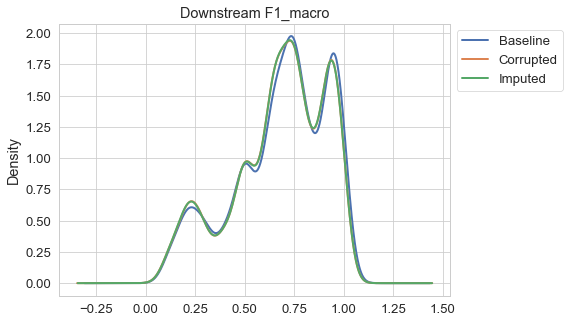

In [12]:
downstream_results.loc[clf_row_idx,["Baseline", "Corrupted", "Imputed"]].plot(kind="kde", title=f"Downstream {CLF_METRIC}", figsize=(7,5))
plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner

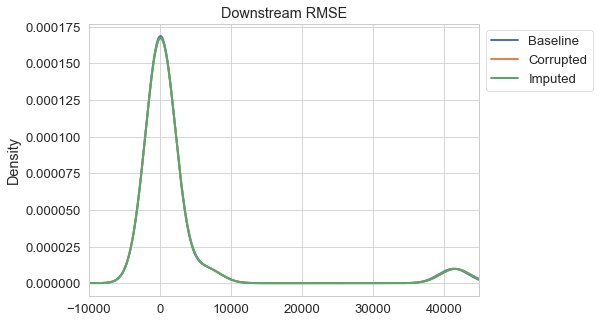

In [13]:
downstream_results.loc[reg_row_idx,["Baseline", "Corrupted", "Imputed"]].plot(kind="kde", title=f"Downstream {REG_METRIC}", figsize=(7,5), xlim=(-10000, 45000))
plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner

### Categorical  Columns (Classification)

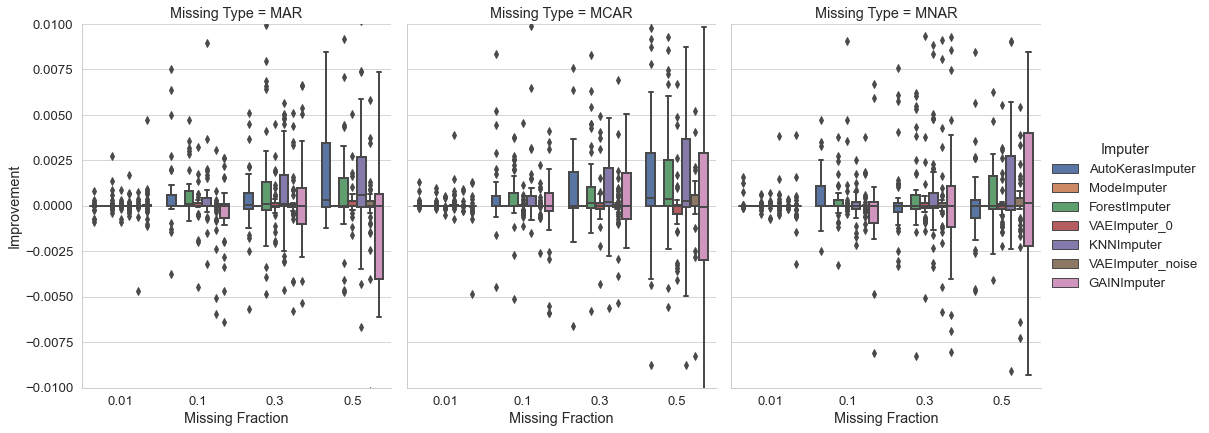

In [14]:
plot_data = downstream_results[clf_row_idx]

ax = sns.catplot(
    x="Missing Fraction", 
    y="Improvement",
    hue="Imputer", 
    #style="Imputer",
    col="Missing Type",
    data=plot_data, 
    kind="box",
    height=6, 
    aspect=.8,
)
ax.set(ylim=(-0.01, 0.01))
plt.savefig(FIGURES_PATH/DOWNSTREAM_RESULT_TYPE/"categorical.svg")

### Numerical Columns (Regression)

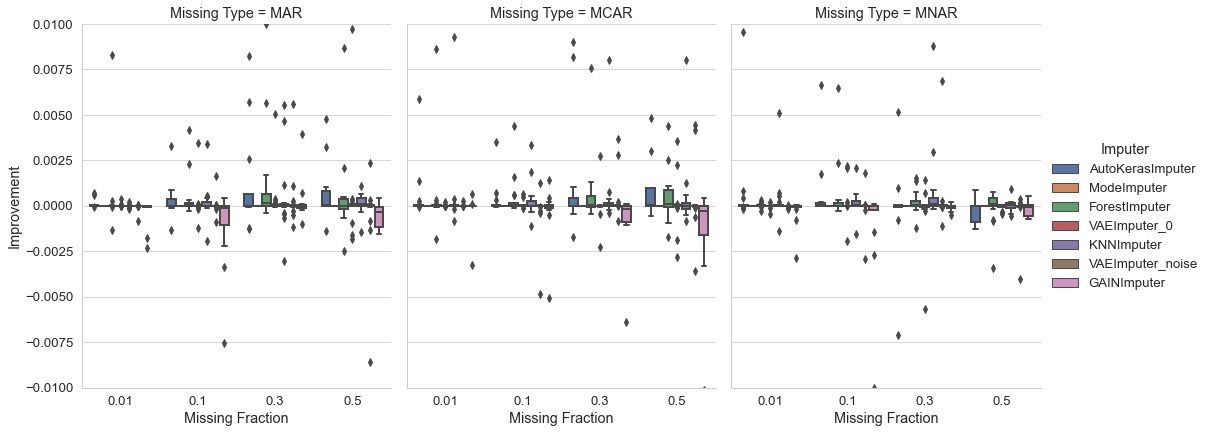

In [15]:
plot_data = downstream_results[reg_row_idx]

ax = sns.catplot(
    x="Missing Fraction", 
    y="Improvement",
    hue="Imputer", 
    #style="Imputer",
    col="Missing Type",
    data=plot_data, 
    kind="box",
    height=6, 
    aspect=.8,
)
ax.set(ylim=(-0.01, 0.01))
plt.savefig(FIGURES_PATH/DOWNSTREAM_RESULT_TYPE/"numerical.svg")

### Heterogenous Columns (Classification and Regression Combined)

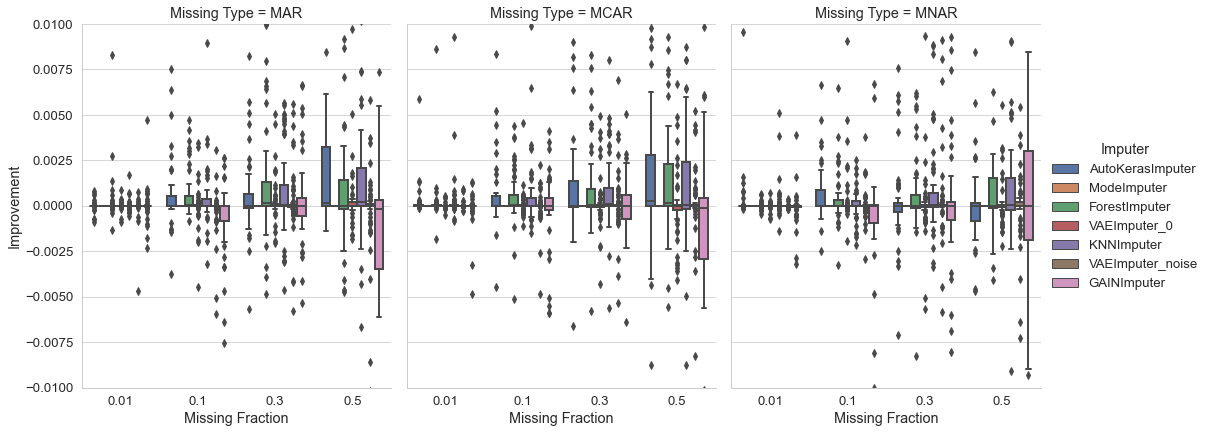

In [16]:
plot_data = downstream_results

ax = sns.catplot(
    x="Missing Fraction", 
    y="Improvement",
    hue="Imputer", 
    #style="Imputer",
    col="Missing Type",
    data=plot_data, 
    kind="box",
    height=6, 
    aspect=.8,
)
ax.set(ylim=(-0.01, 0.01))
plt.savefig(FIGURES_PATH/DOWNSTREAM_RESULT_TYPE/"heterogenous.svg")